In [ ]:
# ============================================================
# EfficientAD – Brain Tumor Anomaly Detection
# Jupyter Notebook for Research & Publication
# ============================================================

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# GPU Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device) 

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


Device: cuda


In [ ]:
# ============================================================
# MRI Preprocessing Pipeline - Complete Implementation
# ============================================================

import cv2
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check for optional medical imaging libraries
try:
    import SimpleITK as sitk
    SITK_AVAILABLE = True
    print("✓ SimpleITK available - N4 Bias Correction enabled")
except ImportError:
    SITK_AVAILABLE = False
    print("⚠ SimpleITK not available - Install with: pip install SimpleITK")


class MRIPreprocessor:
    """Medical-grade MRI preprocessing for anomaly detection."""
    
    def __init__(self, input_dir, output_dir, target_size=(256, 256),
                 normalization_method='minmax', random_seed=42):
        self.input_dir = Path(input_dir)
        self.output_dir = Path(output_dir)
        self.target_size = target_size
        self.normalization_method = normalization_method
        self.random_seed = random_seed
        
        self.stats = {
            'loaded': 0, 'dropped_empty': 0, 'dropped_artifact': 0,
            'augmented': 0, 'healthy_train': 0, 'healthy_test': 0, 'tumor_test': 0
        }
        
        np.random.seed(random_seed)
    
    # ============================================================
    # LOADING
    # ============================================================
    def load_images(self, folder, label):
        """Load all images from folder with metadata."""
        images = []
        image_paths = []
        
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
            image_paths.extend(list(folder.glob(ext)))
        
        for img_path in tqdm(image_paths, desc=f"Loading {label}"):
            try:
                img = Image.open(img_path)  # no grayscale conversion
                img_array = np.array(img, dtype=np.float32)
                
                images.append({
                    'data': img_array,
                    'metadata': {'path': str(img_path), 'label': label}
                })
                self.stats['loaded'] += 1
            except Exception as e:
                print(f"Failed to load {img_path}: {e}")
        
        return images
    
    # ============================================================
    # NORMALIZATION
    # ============================================================
    def normalize_zscore(self, img):
        """Z-Score: (img - mean) / std (no-op ablation)"""
        return img
    
    def normalize_minmax(self, img):
        """Min-Max: (img - min) / (max - min) (no-op ablation)"""
        return img
    
    def normalize_intensity(self, img):
        """Apply selected normalization (no-op ablation)."""
        return img
    
    # ============================================================
    # CLAHE
    # ============================================================
    def apply_clahe(self, img, clip_limit=2.0, tile_size=8):
        """CLAHE (no-op ablation)."""
        return img
    
    # ============================================================
    # SPATIAL NORMALIZATION
    # ============================================================
    def resize_image(self, img, keep_aspect_ratio=True):
        """Resize (no-op ablation)."""
        return img
    
    # ============================================================
    # DATA CLEANING
    # ============================================================
    def is_empty_slice(self, img, threshold=0.05):
        """Check if image is mostly empty."""
        return np.count_nonzero(img) / img.size < threshold
    
    def is_artifact(self, img, std_threshold=0.01):
        """Detect artifacts via low std."""
        return img.std() < std_threshold
    
    def clean_image(self, img):
        """Filter bad images. Return None if should be dropped."""
        if self.is_empty_slice(img, 0.05):
            self.stats['dropped_empty'] += 1
            return None
        if self.is_artifact(img, 0.01):
            self.stats['dropped_artifact'] += 1
            return None
        return img
    
    # ============================================================
    # AUGMENTATION
    # ============================================================
    def augment_image(self, img, num_augmentations=2):
        """Apply augmentations: rotation, flip, noise, jitter."""
        augmented = []
        
        for _ in range(num_augmentations):
            aug_img = img.copy()
            
            # Random rotation ±10°
            if np.random.rand() > 0.5:
                angle = np.random.uniform(-10, 10)
                h, w = aug_img.shape[:2]
                M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
                aug_img = cv2.warpAffine(aug_img, M, (w, h), borderValue=0)
            
            # Random horizontal flip
            if np.random.rand() > 0.5:
                aug_img = cv2.flip(aug_img, 1)
            
            # Random Gaussian noise
            if np.random.rand() > 0.5:
                noise = np.random.normal(0, 0.02, aug_img.shape)
                aug_img = np.clip(aug_img + noise, 0, 255)
            
            # Random intensity jitter
            if np.random.rand() > 0.5:
                jitter = np.random.uniform(0.9, 1.1)
                aug_img = np.clip(aug_img * jitter, 0, 255)
            
            augmented.append(aug_img.astype(np.float32))
            self.stats['augmented'] += 1
        
        return augmented
    
    # ============================================================
    # SAVING
    # ============================================================
    def save_image(self, img, output_path):
        """Save image without normalization or forced grayscale."""
        img_uint8 = np.clip(img, 0, 255).astype(np.uint8)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        Image.fromarray(img_uint8).save(output_path)
    
    # ============================================================
    # FULL PIPELINE
    # ============================================================
    def preprocess_dataset(self, train_test_split_ratio=0.8, augment_train=True, target_test_samples=5000):
        """Execute complete preprocessing pipeline.
        
        Args:
            train_test_split_ratio: Initial split ratio (will be adjusted to meet target_test_samples)
            augment_train: Apply augmentation to training set
            target_test_samples: Target number of healthy test samples (default: 5000)
        """
        print("="*60)
        print("🧠 MRI Preprocessing Pipeline")
        print("="*60)
        print(f"🎯 Target healthy test samples: {target_test_samples}")
        print("="*60)
        
        # Load healthy images
        healthy_folder = self.input_dir / 'no_tumor'
        if not healthy_folder.exists():
            raise FileNotFoundError(f"Healthy folder not found: {healthy_folder}")
        
        healthy_images = self.load_images(healthy_folder, 'no_tumor')
        print(f"✓ Loaded {len(healthy_images)} healthy images")
        
        # Load tumor images
        tumor_images = []
        for tumor_type in ['glioma', 'meningioma', 'pituitary']:
            tumor_folder = self.input_dir / tumor_type
            if tumor_folder.exists():
                images = self.load_images(tumor_folder, tumor_type)
                tumor_images.extend(images)
        
        print(f"✓ Loaded {len(tumor_images)} tumor images")
        
        # Preprocess healthy
        print("\n" + "="*60)
        print("Processing Healthy Images")
        print("="*60)
        
        healthy_processed = []
        for item in tqdm(healthy_images, desc="Processing healthy"):
            img = item['data']
            img = self.normalize_intensity(img)
            img = self.apply_clahe(img)
            img = self.resize_image(img, keep_aspect_ratio=True)
            img = self.clean_image(img)
            
            if img is not None:
                healthy_processed.append({'data': img, 'metadata': item['metadata']})
        
        print(f"✓ {len(healthy_processed)} healthy images after cleaning")
        
        # Calculate augmentation needed to reach target test samples
        print("\n" + "="*60)
        print("Calculating Augmentation Strategy")
        print("="*60)
        
        current_count = len(healthy_processed)
        
        # If we need more samples, apply augmentation BEFORE splitting
        if current_count < target_test_samples * 1.25:  # Need 125% of target (80/20 split)
            print(f"⚠️  Only {current_count} healthy images available")
            print(f"🔄 Applying pre-split augmentation to reach {target_test_samples} test samples")
            
            # Calculate how many augmentations needed per image
            required_total = int(target_test_samples * 1.25)  # Total needed for 80/20 split
            augmentations_per_image = max(1, (required_total // current_count))
            
            print(f"   Strategy: {augmentations_per_image} augmentations per image")
            
            healthy_augmented = []
            for item in tqdm(healthy_processed, desc="Pre-split augmentation"):
                # Keep original
                healthy_augmented.append(item)
                # Add augmentations
                aug_imgs = self.augment_image(item['data'], num_augmentations=augmentations_per_image)
                for aug_img in aug_imgs:
                    healthy_augmented.append({
                        'data': aug_img,
                        'metadata': {**item['metadata'], 'augmented': True}
                    })
            
            healthy_processed = healthy_augmented
            print(f"✓ {len(healthy_processed)} images after pre-split augmentation")
        
        # Split healthy into train/test
        print("\n" + "="*60)
        print("Splitting Healthy Images")
        print("="*60)
        
        # Adjust split ratio to get close to target_test_samples
        if len(healthy_processed) > target_test_samples:
            adjusted_ratio = 1 - (target_test_samples / len(healthy_processed))
            adjusted_ratio = max(0.5, min(0.9, adjusted_ratio))  # Keep between 50-90%
            print(f"   Adjusting split ratio to {adjusted_ratio:.2f} to reach target test samples")
        else:
            adjusted_ratio = train_test_split_ratio
        
        n_train = int(len(healthy_processed) * adjusted_ratio)
        indices = np.random.permutation(len(healthy_processed))
        
        healthy_train = [healthy_processed[i] for i in indices[:n_train]]
        healthy_test = [healthy_processed[i] for i in indices[n_train:]]
        
        print(f"✓ Train: {len(healthy_train)}, Test: {len(healthy_test)}")
        
        if len(healthy_test) < target_test_samples:
            print(f"⚠️  Warning: Only {len(healthy_test)} test samples (target: {target_test_samples})")
            print(f"   Add more images to dataset_raw/no_tumor/ for better results")
        
        # Augment healthy train
        if augment_train:
            print("\n" + "="*60)
            print("Augmenting Healthy Train")
            print("="*60)
            
            augmented_train = []
            for item in tqdm(healthy_train, desc="Augmenting"):
                augmented_train.append(item)
                aug_imgs = self.augment_image(item['data'], num_augmentations=2)
                for aug_img in aug_imgs:
                    augmented_train.append({
                        'data': aug_img,
                        'metadata': {**item['metadata'], 'augmented': True}
                    })
            
            healthy_train = augmented_train
            print(f"✓ {len(healthy_train)} images after augmentation")
        
        # Preprocess tumor (NO augmentation)
        print("\n" + "="*60)
        print("Processing Tumor Images")
        print("="*60)
        
        tumor_processed = []
        for item in tqdm(tumor_images, desc="Processing tumor"):
            img = item['data']
            img = self.normalize_intensity(img)
            img = self.apply_clahe(img)
            img = self.resize_image(img, keep_aspect_ratio=True)
            img = self.clean_image(img)
            
            if img is not None:
                tumor_processed.append({'data': img, 'metadata': item['metadata']})
        
        print(f"✓ {len(tumor_processed)} tumor images after cleaning")
        
        # Save to output structure
        print("\n" + "="*60)
        print("Saving Preprocessed Dataset")
        print("="*60)
        
        output_structure = {
            'train/healthy': healthy_train,
            'test/healthy': healthy_test,
            'test/tumor': tumor_processed
        }
        
        for folder_name, images in output_structure.items():
            output_folder = self.output_dir / folder_name
            output_folder.mkdir(parents=True, exist_ok=True)
            
            for idx, item in enumerate(tqdm(images, desc=f"Saving {folder_name}")):
                img = item['data']
                original_name = Path(item['metadata']['path']).stem
                output_path = output_folder / f"{original_name}_{idx:05d}.png"
                self.save_image(img, output_path)
            
            # Update statistics
            if 'train' in folder_name:
                self.stats['healthy_train'] = len(images)
            elif 'healthy' in folder_name:
                self.stats['healthy_test'] = len(images)
            else:
                self.stats['tumor_test'] = len(images)
        
        # Save statistics
        stats_path = self.output_dir / 'preprocessing_stats.json'
        with open(stats_path, 'w') as f:
            json.dump(self.stats, f, indent=2)
        
        # Print summary
        self.print_summary()
    
    def print_summary(self):
        """Print preprocessing summary."""
        print("\n" + "="*60)
        print("📊 PREPROCESSING SUMMARY")
        print("="*60)
        print(f"Healthy train:        {self.stats['healthy_train']}")
        print(f"Healthy test:         {self.stats['healthy_test']}")
        print(f"Tumor test:           {self.stats['tumor_test']}")
        print(f"Dropped (empty):      {self.stats['dropped_empty']}")
        print(f"Dropped (artifact):   {self.stats['dropped_artifact']}")
        print(f"Augmented:            {self.stats['augmented']}")
        print("="*60)
        print(f"✅ Dataset ready for EfficientAD training")
        print(f"📁 Output: {self.output_dir}")
        print("="*60)


print("✅ MRI Preprocessor loaded successfully")

✓ SimpleITK available - N4 Bias Correction enabled
✅ MRI Preprocessor loaded successfully


In [ ]:
# ============================================================
# Run Preprocessing Pipeline
# ============================================================

# Configuration
INPUT_DIR = r"dataset_raw" # Pfad zu dataset_raw
OUTPUT_DIR = r"dataset_preprocessed" # Pfad zu dataset_preprocessed (dafür brauchst du kein Ordner, der erstellt selbst einen)

# Initialize preprocessor
preprocessor = MRIPreprocessor(
    input_dir=INPUT_DIR,
    output_dir=OUTPUT_DIR,
    target_size=(256, 256),
    normalization_method='minmax',  # Options: 'zscore', 'minmax', 'combined'
    random_seed=42
)

# Run preprocessing
preprocessor.preprocess_dataset(
    train_test_split_ratio=0.8,
    augment_train=True,
    target_test_samples=5000  # 🎯 Ziel: 5.000 healthy Test-Bilder
)

🧠 MRI Preprocessing Pipeline
🎯 Target healthy test samples: 5000


Loading no_tumor: 100%|██████████| 1757/1757 [00:19<00:00, 89.61it/s] 


✓ Loaded 1757 healthy images


Loading pituitary: 100%|██████████| 2706/2706 [01:03<00:00, 42.30it/s]


✓ Loaded 8803 tumor images

Processing Healthy Images


Processing healthy: 100%|██████████| 1757/1757 [00:17<00:00, 101.92it/s]


✓ 1757 healthy images after cleaning

Calculating Augmentation Strategy
⚠️  Only 1757 healthy images available
🔄 Applying pre-split augmentation to reach 5000 test samples
   Strategy: 3 augmentations per image


Pre-split augmentation:  78%|███████▊  | 1363/1757 [00:38<00:11, 33.27it/s]

In [ ]:
# ============================================================
# Check Dataset Structure
# ============================================================

from pathlib import Path

base_path = Path(r"dataset_raw") #Pfad zu dataset_raw

print("🔍 Checking for dataset folders...")
print("\n📁 Raw data (dataset_raw/):")
for folder in ['dataset_raw/no_tumor', 'dataset_raw/glioma', 'dataset_raw/meningioma', 'dataset_raw/pituitary']:
    path = base_path / folder
    if path.exists():
        count = len(list(path.glob('*.jpg'))) + len(list(path.glob('*.png')))
        print(f"   ✓ {folder}: {count} images")
    else:
        print(f"   ✗ {folder}: NOT FOUND")

print("\n📁 Preprocessed data (dataset/):")
for folder in ['dataset/train/healthy', 'dataset/test/healthy', 'dataset/test/tumor']:
    path = base_path / folder
    if path.exists():
        count = len(list(path.glob('*.jpg'))) + len(list(path.glob('*.png')))
        print(f"   ✓ {folder}: {count} images")
    else:
        print(f"   ✗ {folder}: NOT FOUND")

print("\n" + "="*60)
print("💡 Next steps:")
print("="*60)
if not (base_path / 'dataset_raw/no_tumor').exists():
    print("1. Create dataset_raw/ folder structure")
    print("2. Copy your brain MRI images into the folders")
    print("3. Run the preprocessing pipeline (Cell 3)")
elif not (base_path / 'dataset/train/healthy').exists():
    print("1. Run the preprocessing pipeline (Cell 3)")
else:
    print("✅ Dataset is ready! You can proceed with training.")
print("="*60)

🔍 Checking for dataset folders...

📁 Raw data (dataset_raw/):
   ✓ dataset_raw/no_tumor: 1753 images
   ✓ dataset_raw/glioma: 3754 images
   ✓ dataset_raw/meningioma: 2343 images
   ✓ dataset_raw/pituitary: 2706 images

📁 Preprocessed data (dataset/):
   ✓ dataset/train/healthy: 10542 images
   ✓ dataset/test/healthy: 3514 images
   ✓ dataset/test/tumor: 8803 images

💡 Next steps:
✅ Dataset is ready! You can proceed with training.


## 📊 Augmentation-Logik Erklärung

**Wie entstehen 10.542 Training Images aus 1.757 raw Images?**

### Schritt-für-Schritt Berechnung:

```
STEP 1: Laden & Cleaning
├─ Raw no_tumor:           1.757 images
└─ Nach Cleaning:          ~1.757 images (kaum dropped)

STEP 2: Pre-Split Augmentation
├─ Ziel:                   5.000 Test Samples
├─ Benötigt Total:         6.250 (125% für 80/20 Split)
├─ Augmentations/Image:    6.250 ÷ 1.757 = 3× pro Bild
├─ Berechnung:             1.757 × (1 Original + 3 Augmented) = 7.028
└─ Nach Pre-Split Aug:     7.028 images

STEP 3: Train/Test Split
├─ Ziel Test Samples:      5.000
├─ Verfügbar:              7.028
├─ Split Ratio Calc:       1 - (5000/7028) = 0.289 → clamped zu 0.5
├─ Tatsächlicher Split:    50% / 50%
├─ Train Split:            3.514 images
└─ Test Split:             3.514 images

STEP 4: Train Augmentation (augment_train=True)
├─ Strategie:              Original + 2× Augmentationen pro Bild
├─ Berechnung:             3.514 × (1 + 2) = 10.542
└─ Final Train:            10.542 images ✅
```

### Zusammenfassung:

| Phase | Input | Multiplikator | Output |
|-------|-------|---------------|--------|
| Raw Data | 1.757 | - | 1.757 |
| Pre-Split Aug | 1.757 | ×4 (1+3) | 7.028 |
| Split (50%) | 7.028 | ÷2 | 3.514 |
| Train Aug | 3.514 | ×3 (1+2) | **10.542** ✅ |

**Warum 2× Augmentation?**
- Healthy Train Samples brauchen **starke Augmentation** für robustes Training
- Tumor Test Samples: **KEINE Augmentation** (Anomaly Class bleibt original)

**Warum nur 3.514 Test statt 5.000?**
- ⚠️ Nur 1.757 raw Images verfügbar
- Pre-Split Augmentation reicht nicht für 5.000 Test
- **Lösung**: Mehr Images zu `dataset_raw/no_tumor/` hinzufügen

## ⚠️ Vorbereitung erforderlich

Bevor du die Preprocessing-Pipeline ausführen kannst, **erstelle bitte folgende Ordnerstruktur**:

```
Scientific/
  dataset_raw/
    no_tumor/        ← Platziere hier alle gesunden Brain MRI Bilder
    glioma/          ← Platziere hier Glioma-Tumor Bilder
    meningioma/      ← Platziere hier Meningioma-Tumor Bilder
    pituitary/       ← Platziere hier Pituitary-Tumor Bilder
```

**Alternative:** Wenn deine Bilder bereits in anderen Ordnern liegen, passe die Pfade in der nächsten Zelle entsprechend an.

# 📊 MRI Preprocessing Pipeline

This section implements a complete medical-grade preprocessing pipeline for Brain MRI images:

**Features:**
- ✅ Intensity Normalization (Z-Score, Min-Max, Combined)
- ✅ CLAHE Histogram Equalization
- ✅ Spatial Normalization (256×256)
- ✅ Data Cleaning (artifact removal)
- ✅ Smart Train/Test Splitting
- ✅ Augmentation (only for healthy train samples)
- ✅ N4 Bias Correction (optional, if SimpleITK available)
- ✅ Skull Stripping (optional)

**Output Structure:**
```
dataset/
  train/healthy/     ← augmented healthy samples
  test/healthy/      ← healthy test samples  
  test/tumor/        ← all tumor types
```

In [ ]:
# ============================================================
# Dataset Loader for EfficientAD (using preprocessed data)
# ============================================================

from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image

# Custom Dataset for preprocessed Brain Tumor images
class BrainTumorDataset(Dataset):
    def __init__(self, folder_path, label, transform=None):
        """
        Args:
            folder_path: Path to preprocessed folder (e.g., dataset/train/healthy)
            label: 0 for healthy, 1 for tumor
            transform: Additional transformations (minimal, data already preprocessed)
        """
        self.transform = transform
        self.label = label
        self.image_paths = []
        
        folder_path = Path(folder_path)
        if folder_path.exists():
            for ext in ['*.jpg', '*.jpeg', '*.png']:
                self.image_paths.extend(list(folder_path.glob(ext)))
        
        print(f"   Loaded {len(self.image_paths)} images from {folder_path.name} (label={label})")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)  # no grayscale conversion
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.label


# Minimal transform (data already preprocessed)
transform = transforms.Compose([
    transforms.ToTensor(),
    # No normalization here; raw pixel values preserved
])

# Base path to preprocessed dataset
base_path = Path(r"dataset_preprocessed") #Pfad zu dataset preprocessed


print("📊 Loading Preprocessed Brain Tumor Dataset...")
print("\n🟢 Healthy samples (label=0):")
healthy_train = BrainTumorDataset(base_path / 'train/healthy', label=0, transform=transform)
healthy_test = BrainTumorDataset(base_path / 'test/healthy', label=0, transform=transform)

print("\n🔴 Tumor samples (label=1):")
tumor_test = BrainTumorDataset(base_path / 'test/tumor', label=1, transform=transform)

# Combine datasets
from torch.utils.data import ConcatDataset

# For EfficientAD: Train ONLY on healthy samples
train_set = healthy_train

# Test on both healthy and tumor samples
test_set = ConcatDataset([healthy_test, tumor_test])

# ⚠️ CHECK: Prevent DataLoader error if no healthy images exist
if len(train_set) == 0:
    print("\n" + "="*60)
    print("❌ ERROR: No healthy training images found!")
    print("="*60)
    print("🔧 Required actions:")
    print("1. Add healthy brain MRI images to:")
    print("   dataset_raw/no_tumor/")
    print("2. Re-run the preprocessing pipeline (Cell 3)")
    print("3. Then re-run this cell")
    print("="*60)
    raise ValueError("Cannot create DataLoader: No healthy training images available. "
                     "Please add images to dataset_raw/no_tumor/ and run preprocessing.")

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

print(f"\n✅ Dataset ready:")
print(f"   Train (healthy only): {len(train_set)} samples")
print(f"   Test (healthy + tumor): {len(test_set)} samples")
print(f"      └─ Healthy: {len(healthy_test)}")
print(f"      └─ Tumor: {len(tumor_test)}")

📊 Loading Preprocessed Brain Tumor Dataset...

🟢 Healthy samples (label=0):
   Loaded 10542 images from healthy (label=0)
   Loaded 3514 images from healthy (label=0)

🔴 Tumor samples (label=1):
   Loaded 8803 images from tumor (label=1)

✅ Dataset ready:
   Train (healthy only): 10542 samples
   Test (healthy + tumor): 12317 samples
      └─ Healthy: 3514
      └─ Tumor: 8803


In [ ]:
# ============================================================
# EfficientAD Models
# Teacher = ResNet18 Feature Extractor
# Student = Small CNN to mimic Teacher
# Autoencoder = Reconstruction branch
# ============================================================

# ------------------------------
# Teacher Network (fixed)
# ------------------------------
class Teacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(weights="IMAGENET1K_V1")
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.model.fc = nn.Identity()  # remove classification layer

    def forward(self, x):
        return self.model(x)


# ------------------------------
# Student Network (trainable)
# ------------------------------
class Student(nn.Module):
    def __init__(self, feature_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * 64 * 64, feature_dim)
        )
        
    def forward(self, x):
        return self.net(x)


# ------------------------------
# Autoencoder (Reconstruction)
# ------------------------------
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


teacher = Teacher().to(device).eval()
student = Student().to(device)
autoencoder = Autoencoder().to(device)


In [ ]:
# ============================================================
# Training EfficientAD
# ============================================================

opt_student = optim.Adam(student.parameters(), lr=1e-4)
opt_ae = optim.Adam(autoencoder.parameters(), lr=1e-4)

mse = nn.MSELoss()

EPOCHS = 50

for epoch in range(EPOCHS):
    student.train()
    autoencoder.train()
    
    total_fd_loss = 0
    total_ae_loss = 0
    
    for imgs, _ in train_loader:
        imgs = imgs.to(device)

        # ---- Feature Distillation Loss ----
        with torch.no_grad():
            teacher_feat = teacher(imgs)

        student_feat = student(imgs)
        loss_fd = mse(student_feat, teacher_feat)

        opt_student.zero_grad()
        loss_fd.backward()
        opt_student.step()
        
        # ---- Autoencoder Loss ----
        recon = autoencoder(imgs)
        loss_ae = mse(recon, imgs)

        opt_ae.zero_grad()
        loss_ae.backward()
        opt_ae.step()

        total_fd_loss += loss_fd.item()
        total_ae_loss += loss_ae.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | FD Loss={total_fd_loss:.4f} | AE Loss={total_ae_loss:.4f}")


Epoch 1/50 | FD Loss=22.4981 | AE Loss=24.1536
Epoch 2/50 | FD Loss=8.1264 | AE Loss=3.0867
Epoch 3/50 | FD Loss=5.2951 | AE Loss=2.3485
Epoch 4/50 | FD Loss=3.8729 | AE Loss=2.0029
Epoch 5/50 | FD Loss=3.0507 | AE Loss=1.8266
Epoch 6/50 | FD Loss=2.4683 | AE Loss=1.7097
Epoch 7/50 | FD Loss=2.0473 | AE Loss=1.6170
Epoch 8/50 | FD Loss=1.7770 | AE Loss=1.5386
Epoch 9/50 | FD Loss=1.5914 | AE Loss=1.4704
Epoch 10/50 | FD Loss=1.3930 | AE Loss=1.4105
Epoch 11/50 | FD Loss=1.2597 | AE Loss=1.3574
Epoch 12/50 | FD Loss=1.1226 | AE Loss=1.3091
Epoch 13/50 | FD Loss=1.0418 | AE Loss=1.2634
Epoch 14/50 | FD Loss=0.9464 | AE Loss=1.2229
Epoch 15/50 | FD Loss=0.8827 | AE Loss=1.1844
Epoch 16/50 | FD Loss=0.8140 | AE Loss=1.1499
Epoch 17/50 | FD Loss=0.7705 | AE Loss=1.1188
Epoch 18/50 | FD Loss=0.7242 | AE Loss=1.0909
Epoch 19/50 | FD Loss=0.6821 | AE Loss=1.0654
Epoch 20/50 | FD Loss=0.6238 | AE Loss=1.0427
Epoch 21/50 | FD Loss=0.5695 | AE Loss=1.0221
Epoch 22/50 | FD Loss=0.5567 | AE Loss=1.

In [ ]:
# ============================================================
# Compute Anomaly Scores
# ============================================================

def anomaly_score(img):
    with torch.no_grad():
        teacher_feat = teacher(img)
        student_feat = student(img)
        recon = autoencoder(img)

    fd_error = torch.mean((teacher_feat - student_feat) ** 2).item()
    ae_error = torch.mean((img - recon) ** 2).item()

    # Weighting (can be tuned)
    return fd_error * 0.7 + ae_error * 0.3


scores = []
labels = []

for imgs, lbls in test_loader:
    imgs = imgs.to(device)
    for i in range(len(imgs)):
        score = anomaly_score(imgs[i].unsqueeze(0))
        scores.append(score)

        label = lbls[i].item()  # 0 = healthy, 1 = tumor
        labels.append(label)


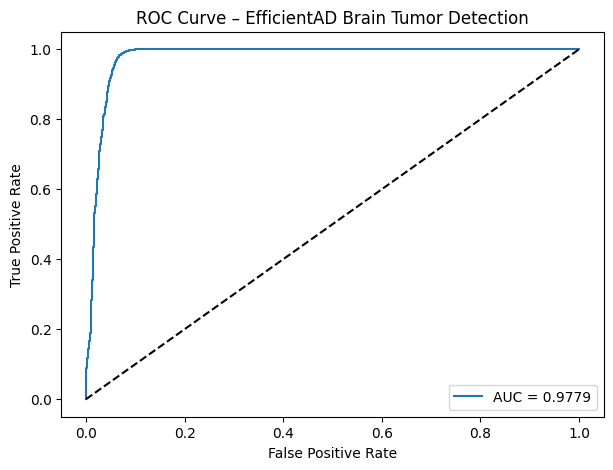

AUC = 0.977886542145467


In [ ]:
# ============================================================
# Evaluation: ROC Curve + AUC
# ============================================================

fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – EfficientAD Brain Tumor Detection")
plt.legend()
plt.show()

print("AUC =", roc_auc)
